# CS109A Final Project

Project: Automatic Playlist Recommendation

Team spotiFIRE members (Group 41): Sunil Chomal, Ria Cheruvu, Guido Camps

**Note:** We recommend downloading the notebook and viewing it locally, instead of on GitHub, to interact with the ipywidgets.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Acquisition" data-toc-modified-id="Data-Acquisition-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Acquisition</a></span></li><li><span><a href="#Loading-in-the-data" data-toc-modified-id="Loading-in-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading in the data</a></span></li><li><span><a href="#Recommender-system-model" data-toc-modified-id="Recommender-system-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Recommender system model</a></span></li><li><span><a href="#User-Interface" data-toc-modified-id="User-Interface-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>User Interface</a></span></li><li><span><a href="#Metrics:-R-precision" data-toc-modified-id="Metrics:-R-precision-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Metrics: R-precision</a></span><ul class="toc-item"><li><span><a href="#Basis" data-toc-modified-id="Basis-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Basis</a></span></li><li><span><a href="#1.-Inputs" data-toc-modified-id="1.-Inputs-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>1. Inputs</a></span></li><li><span><a href="#2.-Generate-Search-Index" data-toc-modified-id="2.-Generate-Search-Index-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>2. Generate Search Index</a></span></li><li><span><a href="#3.-Search" data-toc-modified-id="3.-Search-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>3. Search</a></span></li><li><span><a href="#Step-0---Setup" data-toc-modified-id="Step-0---Setup-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Step 0 - Setup</a></span></li><li><span><a href="#Use-BERT-Language-Models-to-generate-recommendations" data-toc-modified-id="Use-BERT-Language-Models-to-generate-recommendations-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span><strong>Use BERT Language Models to generate recommendations</strong></a></span></li><li><span><a href="#Step-1:-Inputs" data-toc-modified-id="Step-1:-Inputs-5.7"><span class="toc-item-num">5.7&nbsp;&nbsp;</span>Step 1: Inputs</a></span></li><li><span><a href="#Step-2:-Generate-the-Index" data-toc-modified-id="Step-2:-Generate-the-Index-5.8"><span class="toc-item-num">5.8&nbsp;&nbsp;</span>Step 2: Generate the Index</a></span></li><li><span><a href="#Step-3:-Generate-recommendations" data-toc-modified-id="Step-3:-Generate-recommendations-5.9"><span class="toc-item-num">5.9&nbsp;&nbsp;</span>Step 3: Generate recommendations</a></span></li><li><span><a href="#Use-GPT-2-Language-Models-to-generate-recommendations" data-toc-modified-id="Use-GPT-2-Language-Models-to-generate-recommendations-5.10"><span class="toc-item-num">5.10&nbsp;&nbsp;</span><strong>Use GPT-2 Language Models to generate recommendations</strong></a></span></li><li><span><a href="#Step-1---Input" data-toc-modified-id="Step-1---Input-5.11"><span class="toc-item-num">5.11&nbsp;&nbsp;</span>Step 1 - Input</a></span></li><li><span><a href="#Step-2---Index" data-toc-modified-id="Step-2---Index-5.12"><span class="toc-item-num">5.12&nbsp;&nbsp;</span>Step 2 - Index</a></span></li><li><span><a href="#Step-3---Recommendations" data-toc-modified-id="Step-3---Recommendations-5.13"><span class="toc-item-num">5.13&nbsp;&nbsp;</span>Step 3 - Recommendations</a></span></li></ul></li><li><span><a href="#Combining-the-recommendations" data-toc-modified-id="Combining-the-recommendations-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Combining the recommendations</a></span></li></ul></div>

In [2]:
!pip install spotipy

  Created wheel for spotipy: filename=spotipy-2.4.4-cp36-none-any.whl size=12336 sha256=ee6bb03ad9819003cb5c9458ab035576cf6abf9e7b360cd72a72b35fcb955299
  Stored in directory: /root/.cache/pip/wheels/76/28/19/a86ca9bb0e32dbd4a4f580870250f5aeef852870578e0427e6
Successfully built spotipy


In [0]:
import pandas as pd
import numpy as np
import random
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import Javascript
from IPython.display import HTML
from sklearn.cluster import KMeans

In [0]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [6]:
from google.colab import files
uploaded = files.upload()

Saving new_feature_data_songs999.csv to new_feature_data_songs999.csv


## Data Acquisition

In this section, we retrieve audio features from Spotipy API. We registered for and created a credential for our specific application/project.

In [0]:
spotify = spotipy.Spotify()

#Establish Spotipy credential
client_credentials_manager = SpotifyClientCredentials(client_id='9f4add2b5f494ce8b926497a96bf6d13', client_secret='43259646240a4b99a54feed393730d6f')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

Due to computational concerns and the project allowing the use of a subset of the dataset, we read in one .csv file at a time. In this case, we did this for three different .csv files - an example of what we did for one of the .csv files is shown here. 

In [0]:
#Read in one csv file from dataset
first_dataframe = pd.read_csv('songs999.csv')

Below, we retrieve the audio features for each track using Spotipy and add the results to the original dataframe. Although the code below is bulky, we found the following approach to be the most efficient. Methods such as dataframe.insert, dataframe.assign(), etc. were leading to errors or failing during runtime, so we used the following approach instead.

In [0]:
#Create new rows in dataframe
first_dataframe['acousticness'] = ''
first_dataframe['duration_ms'] = ''
first_dataframe['duration_ms'] = ''
first_dataframe['energy'] = ''
first_dataframe['liveness'] = ''
first_dataframe['loudness'] = ''
first_dataframe['tempo'] = ''
first_dataframe['valence'] = ''
first_dataframe['danceability'] = ''
first_dataframe['speechiness'] = ''

for i in range(len(first_dataframe['track_uri'])):
    #Retrieve audio features from Spotipy and add to dataframe
    json_obj = json.dumps(sp.audio_features(first_dataframe['track_uri'][i]))
    first_dataframe['danceability'][i] = json.loads(json_obj)[0]['danceability']
    first_dataframe['speechiness'][i] = json.loads(json_obj)[0]['speechiness']
    first_dataframe['acousticness'][i] = json.loads(json_obj)[0]['acousticness']
    first_dataframe['duration_ms'][i] = json.loads(json_obj)[0]['duration_ms']
    first_dataframe['energy'][i] = json.loads(json_obj)[0]['energy']
    first_dataframe['liveness'][i] = json.loads(json_obj)[0]['liveness']
    first_dataframe['loudness'][i] = json.loads(json_obj)[0]['loudness']
    first_dataframe['tempo'][i] = json.loads(json_obj)[0]['tempo']
    first_dataframe['valence'][i] = json.loads(json_obj)[0]['valence']

In [0]:
#Save dataframe to csv file
first_dataframe.to_csv('new_feature_data_songs999.csv')

## Loading in the data

Below, we load in the data and start inspecting the features.

In [7]:
songs_df = pd.read_csv('new_feature_data_songs999.csv')
del songs_df['Unnamed: 0']
songs_df.head()

,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,acousticness,energy,liveness,loudness,tempo,valence,danceability,speechiness
0,0.0,0.0,Yiruma,spotify:track:7fnqltLx83HsYLQajzCYRk,spotify:artist:0fauHpmSHwodVYIjTqOGHz,River Flows In You,spotify:album:0vIR7YccgfLA1f5wcXZa4Z,185013.0,River Flows In You,0.988,0.2070,0.0880,-21.487,144.547,0.1090,0.320,0.0512
1,0.0,1.0,Frédéric Chopin,spotify:track:3w8507pR0Ncycrol0ZJOwP,spotify:artist:7y97mc3bZRFXzT2szRM4L4,Ballade No. 4 in F minor Op. 52,spotify:album:2ML75R6Z1LEFgPNZS0Ce3D,676000.0,The Best of Chopin,0.993,0.1050,0.1030,-24.507,70.014,0.0377,0.270,0.0439
2,0.0,2.0,Alexander Pitamic,spotify:track:59E6rPql7W8q2sodZpg1qQ,spotify:artist:4TuTJcUBhYyPoHYTSQzGAM,"Serenade für Streicher Nr. 13, G-Dur, KV 525: ...",spotify:album:3V8JHEeOhi7Z765C6v3Pqr,391000.0,"Wolfgang Amadeus Mozart: Sinfonie Nr. 29, A-Du...",0.952,0.0763,0.1000,-20.524,122.174,0.4100,0.544,0.0505
3,0.0,3.0,Johann Sebastian Bach,spotify:track:48BSXfxyLLxDIp934Is2A9,spotify:artist:5aIqB5nVVvmFsvSdExz408,"Cello Suite No. 1 in G Major, BWV 1007: I. Pre...",spotify:album:2cj4D33pmIvDCiDYWg80Nj,132120.0,"Bach, J.S.: 6 Suites for Solo Cello, Bwv 1007-...",0.990,0.2130,0.0859,-20.577,79.423,0.6170,0.341,0.0715
4,0.0,4.0,Hans Zimmer,spotify:track:4aW4Dpz3gpb619hBXDrFUa,spotify:artist:0YC192cP3KPCRWx8zr8MfZ,"Honor [Main Title Theme From ""The Pacific""]",spotify:album:0NH1WrtzRBlZS1VJX2XnXr,176587.0,The Pacific (Music From the HBO Miniseries),0.335,0.2760,0.1100,-14.830,68.619,0.0575,0.190,0.0346


Let's take a look at the dataset in detail using the describe() function.

In [8]:
songs_df.describe()

,pid,pos,duration_ms,acousticness,energy,liveness,loudness,tempo,valence,danceability,speechiness
count,42498.000000,42498.000000,4.249800e+04,42498.000000,42498.000000,42498.000000,42498.000000,42498.000000,42498.000000,42498.000000,42498.000000
mean,327.613911,53.902278,2.347531e+05,0.234791,0.644855,0.190124,-7.404046,121.321720,0.503476,0.611574,0.096378
std,194.724866,48.609019,7.466447e+04,0.275928,0.209280,0.156695,3.806717,28.644292,0.247057,0.163806,0.101408
min,0.000000,0.000000,7.229000e+03,0.000000,0.000020,0.000000,-42.236000,0.000000,0.000000,0.000000,0.000000
25%,160.000000,16.000000,1.971330e+05,0.021200,0.511000,0.094100,-8.854750,98.991250,0.305000,0.503000,0.036300
50%,323.000000,39.000000,2.248670e+05,0.108000,0.674000,0.127000,-6.588500,120.041000,0.497000,0.623000,0.052000
75%,496.000000,78.000000,2.600930e+05,0.372000,0.808000,0.242000,-4.954000,139.953000,0.701000,0.733000,0.108000
max,657.000000,248.000000,5.403559e+06,0.996000,1.000000,0.998000,1.586000,220.169000,0.996000,0.988000,0.956000


We see the following:

**Categorical variables**:

- artist_name
- track_uri
- artist_uri
- track_name
- album_uri
- album_name

**Numerical variables**:

- pid
- pos
- duration_ms
- acousticness
- energy
- liveness
- loudness
- tempo
- valence
- danceability
- speechiness

For the numerical variables, we notice that some of the variables have a different order of magnitude compared to the other features. For example, the "Tempo" variable has values ranging from 0 to 220, the "Loudness" variable had values ranging from -42 to approximately 2, and the "danceability" variable has values ranging from 0 to approximately 1. This suggests that scaling the dataset would be useful to account for the features with varying orders of magnitude - which we will consider later.

First, we need to make sure that we drop NAN values from the dataframe, which we can achieve efficiently using the dropna() function.

In [0]:
#Drop NA values from songs_df
songs_df = songs_df.dropna()

Now, we will perform the preliminary EDA.

First, let's look at the number of unique artists in the list (there are 8,303).

In [10]:
#number of unique artists within the lists
len(songs_df['artist_name'].unique())

8303

Below we see the top ten artist entries in the datafile.

In [11]:
#get freq of artists
songs_df['artist_name'].value_counts().head(10)

Drake                       501
Kanye West                  237
Kendrick Lamar              229
Electric Light Orchestra    200
Rihanna                     186
Lil Uzi Vert                183
Imagine Dragons             178
The Weeknd                  170
John Mayer                  169
Future                      155
Name: artist_name, dtype: int64

Below we see the frequency distribution of the artists: there is a large skew to the data set, with a small number of artists having a large presence, and to the overly large majority being ‘one-trick-ponies’, having only a single hit song in the database. One hypothesis we can make from these insights is that users would be more open to listening to songs from other artists that aren't (yet) part of their playlist, rather than tracks from the same artists the users listen to, given that most artists have a small presence.

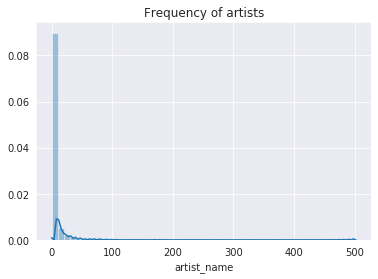

In [12]:
#get freq of artists into var
artist_frequencies = songs_df['artist_name'].value_counts()
#try to make frequency histogram
sns.set_style('darkgrid')
sns.distplot(artist_frequencies)
plt.title("Frequency of artists");

Now, let's dive deeper into the data. Let's look at a boxplot overview of the data of the songs for 8 features (accousticness, energy, liveness, loudness, tempo, valence, danceability, and speechiness), on the basis of which we will try to categorize songs and predict choice.

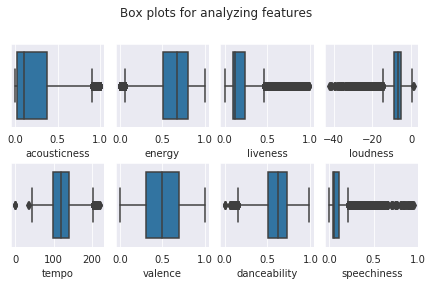

In [13]:
#this is using pos/pid/duration as a placeholder
#
#the idea is to use the song information as we were able to gather it: 
f, axes = plt.subplots(2, 4)
plt.suptitle("Box plots for analyzing features")
song_features = songs_df[['acousticness','energy','liveness','loudness','tempo','valence','danceability','speechiness']]
sns.boxplot(song_features['acousticness'], ax=axes[0,0])
sns.boxplot(song_features['energy'], ax=axes[0,1])
sns.boxplot(song_features['liveness'], ax=axes[0,2])
sns.boxplot(song_features['loudness'], ax=axes[0,3])
sns.boxplot(song_features['tempo'], ax=axes[1,0])
sns.boxplot(song_features['valence'], ax=axes[1,1])
sns.boxplot(song_features['danceability'], ax=axes[1,2])
sns.boxplot(song_features['speechiness'], ax=axes[1,3])
plt.tight_layout()
plt.subplots_adjust(top=0.85);

We see most of the distributions are skewed, except for tempo and valence,for example.

For examples, there appears to be some skewing in data for liveness, loudness and speechiness. Liveness might be a multimodal distribution of liveness of regular songs, and a secondary group of actual songs for live performances. For speechiness, this might be an effect of music type (e.g. rock/balads versus rap songs).

As we'll notice later in the clustering section, the wide range of the distributions for certain features such as danceability will come in handy when data points are assigned to different clusters and we seek seperability of the clusteres for interpretation. By analyzing the box plots, we were able to develop this intution early-on and understand what to expect when moving on to the clustering analysis.

Next, we inspect a correlation matrix for the features to see if we have any issues with overlapping features or risk multicollinearity in further analysis

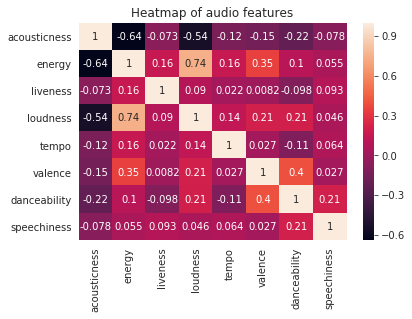

In [14]:
plt.title("Heatmap of audio features")
sns.heatmap(song_features.corr(), annot=True);

We only see particularly high correlations between acousticness and energy and acousticness and loudnness, although in other cases the dataset doesn't demonstrate high multicollinearity. Let's look in this detail.

Let's look at the correlation plots for four features in particular:

Overall there seems to be a negative correlation for accousticness and energy (e.g. acoustic songs are more often low-energy), a positive relationship between loudness and energy (more energetic songs are louder). Valance and danceability are positively correlated, as are energy and valence. Since we see interesting relationships between these variables that may be encoding musical sensabilities, we chose to keep all the features in the dataset and see how they inform our analysis.

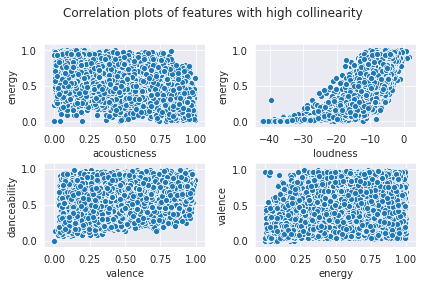

In [15]:
f, axes = plt.subplots(2, 2)
plt.suptitle("Correlation plots of features with high collinearity")
sns.scatterplot(song_features['acousticness'], song_features['energy'], ax=axes[0,0])
sns.scatterplot(song_features['loudness'], song_features['energy'], ax=axes[0,1])
sns.scatterplot(song_features['valence'], song_features['danceability'],ax=axes[1,0])
sns.scatterplot(song_features['energy'], song_features['valence'], ax=axes[1,1])
plt.tight_layout()
plt.subplots_adjust(top=0.85);

**K-means Clustering:**

As part of the preliminary EDA, we performed K-means clustering in order to find any interesting insights in the data through unsupervised learning (this came in handy later for the recommender system approach).

First, as we discussed above, scaling the dataset would be useful, so we utilize the StandardScaler to scale our data accordingly.

Here, we make the decision not to scale the pid and pos columns, given that the values/ordering of the columns might be important.

In [0]:
#Get numerical features
num_vars = songs_df.drop(['pid', 'pos', 'artist_name', 'track_uri', 'artist_uri', 'track_name', 'album_uri', 'album_name'], axis=1)
# Fit the scaler on the training data
scaler = StandardScaler().fit(num_vars)
# Scale the entire dataset
new_scaled_df = pd.DataFrame(scaler.transform(num_vars), columns = num_vars.columns)

Now, let's train a KMeans Algorithm and predict the clusters for the data.

In [17]:
# Use random_state so the cluster assignment doesn't change
kmeans = KMeans(n_clusters=3, random_state=969)
kmeans.fit(new_scaled_df)
y_kmeans = kmeans.predict(new_scaled_df)
y_kmeans

array([1, 1, 1, ..., 1, 0, 0], dtype=int32)

Below, we demonstrate the distribution of the data points across the 3 clusters - we see majority of the data points have been assigned to Cluster 0.

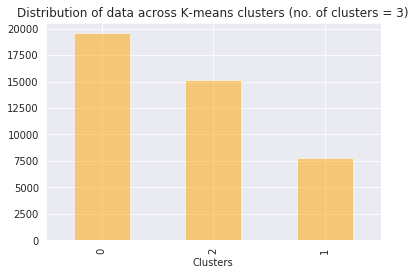

In [18]:
pd.value_counts(y_kmeans).plot(kind="bar", color="orange", alpha = 0.5)
plt.title("Distribution of data across K-means clusters (no. of clusters = 3)")
plt.xlabel("Clusters");

It is challenging to interpret the results of unsupervised learning algorithms, given there are no labels. We can use one approach where we analyze the distribution of values with respect to the K-means clusters.

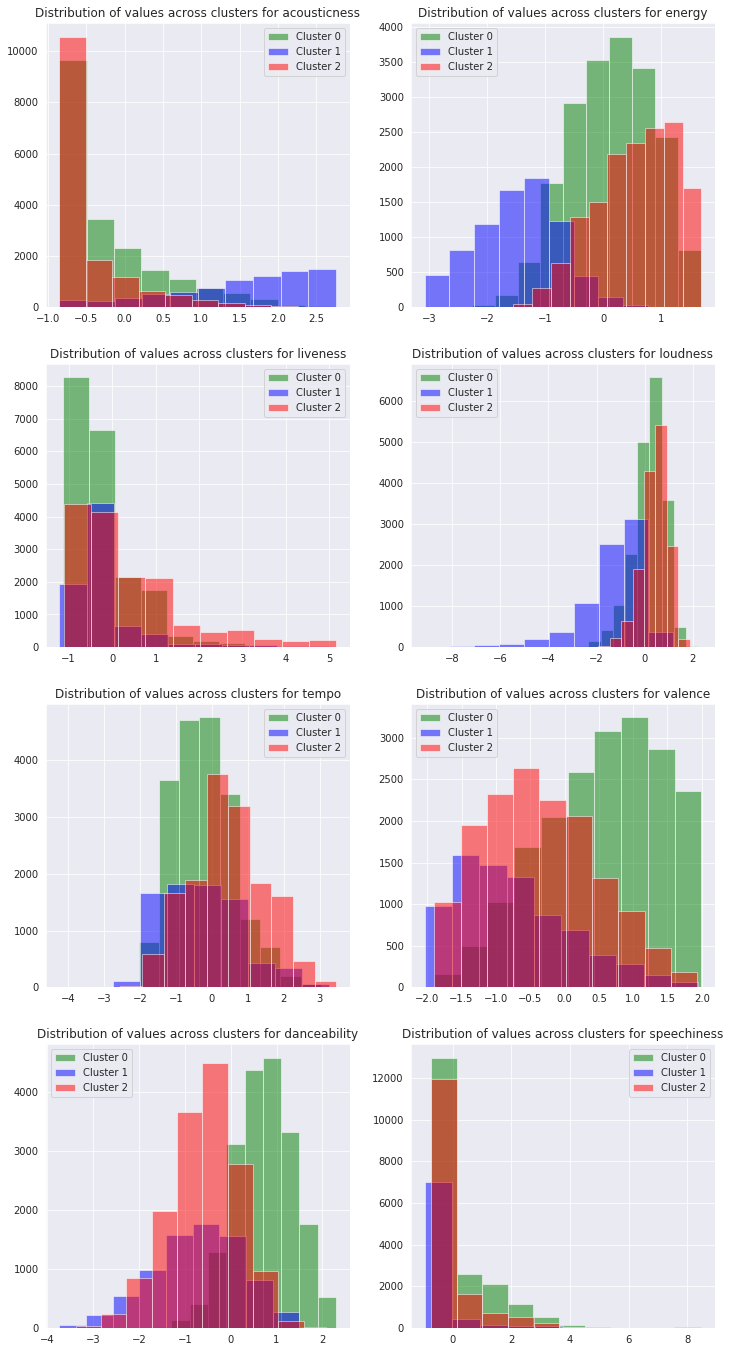

In [19]:
list_of_audio_features = ['acousticness', 'energy', 'liveness', 'loudness', 'tempo', 'valence', 'danceability', 'speechiness']
fig, axes = plt.subplots(4,2,figsize=(12,24))
axes = axes.ravel()

for ax, i in zip(axes, list_of_audio_features):
    # plt.figure()
    ax.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 0, str(i)], color="green", alpha=0.5, label="Cluster 0")
    ax.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 1, str(i)], color="blue", alpha=0.5, label="Cluster 1")
    ax.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 2, str(i)], color="red", alpha=0.5, label="Cluster 2")
    #plt.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 3, str(i)], color="orange", alpha=0.5, label="Cluster 3")
    #plt.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 4, str(i)], color="pink", alpha=0.5, label="Cluster 4")
    #plt.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 5, str(i)], color="brown", alpha=0.5, label="Cluster 5")
    ax.legend();
    ax.set_title("Distribution of values across clusters for " + str(i))

We see some interesting results. In particular, we see the distributions for the clusters seem to overlap a lot, but we can make out a few trends. For example, it seems that Cluster 0 contains data points with medium acousticness, medium energy, high valence, and high danceability. Cluster 1 seems to contain data points that have high acousticness, low energy, low valence, and medium danceability. Cluster 2 contains data points with medium/low acousticness, high energy, medium valence, and medium danceability.

For variables such as "speechiness", it is harder to identify the trends, although we can generally say that Cluster 0 contains data points with relatively higher speechiness, Cluster 1 contains data points with low speechiness, and Cluster 2 contains data points with medium speechiness.

Given that even after scaling the data, the order of the rows remains the same, we can inspect which songs (from the original dataframe that still contains the categorical variables and the original values of the featurs) were assigned to what Clusters.

We see in this case, "Give 'Em a Chance" was assigned to Cluster 0 - we do see it has low acousticness, relatively high energy,  high valence and high danceability which matches our interpretation for Cluster 0.

"River Flows In You" was assigned to Cluster 1 -  we see high acousticness, low energy, etc. which matches our interpretation for Cluster 1.

"Requiem For A Tower" was assigned to Cluster 2 - we see medium/low acousticness, high energy, etc. which matches our interpretation for Cluster 2.

In this case, we have only cluster (Cluster 0) that represents happy tracks. We experimented with different numbers of clusters, and observed similar observations in terms of seperability of features even with more clusters, so we decided to choose three clusters and move forward.

In [148]:
songs_df.loc[pd.DataFrame(y_kmeans)[0] == 0].head(1)[['track_name', 'artist_name', 'acousticness',	'energy',	'liveness',	'loudness',	'tempo',	'valence',	'danceability',	'speechiness']]

,track_name,artist_name,acousticness,energy,liveness,loudness,tempo,valence,danceability,speechiness
6,Give 'Em a Chance,David Robidoux,0.093,0.66,0.114,-9.152,114.955,0.307,0.851,0.0462


In [149]:
songs_df.loc[pd.DataFrame(y_kmeans)[0] == 1].head(1)[['track_name', 'artist_name', 'acousticness',	'energy',	'liveness',	'loudness',	'tempo',	'valence',	'danceability',	'speechiness']]

,track_name,artist_name,acousticness,energy,liveness,loudness,tempo,valence,danceability,speechiness
0,River Flows In You,Yiruma,0.988,0.207,0.088,-21.487,144.547,0.109,0.32,0.0512


In [150]:
songs_df.loc[pd.DataFrame(y_kmeans)[0] == 2].head(1)[['track_name', 'artist_name', 'acousticness',	'energy',	'liveness',	'loudness',	'tempo',	'valence',	'danceability',	'speechiness']]

,track_name,artist_name,acousticness,energy,liveness,loudness,tempo,valence,danceability,speechiness
9,Requiem For A Tower,London Music Works,0.221,0.605,0.106,-9.956,157.05,0.195,0.365,0.04


## Recommender system model

Below, we have the recommender system algorithm itself that is trained on the entire dataset and utilizes the cosine similarity metric. As we are deploying the model on sparse input, we need to use the brute-force search algorithm to compute the nearest neighbors, per the documentation (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors).

In [23]:
#Create sparse matrix using pivot_table using track name as the index, and fill in missing values.
#We consulted beckernick.github.io/music_recommender/ in order to learn more about this approach.

orig = songs_df.pivot_table(index='track_name', columns = 'pid').fillna(0)
pivoted = csr_matrix(orig)

#We utilize n_neighbors = 5 for default queries with this model
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(pivoted)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

## User Interface

In this section, we implement the user interface (UI) in addition to the recommender system model.

First, as part of the UI, we have the user take a short quiz to helps us understand them better.

Please follow the instructions carefully - as we are using the ipywidgets, it is important to do so, or your choices may be reset.

The first question is for the sentiment analysis model; the rest of the quiz questions correspond to the recommender system.

Note: Our sentiment analysis model currently supports taking one song as input, due to time constraints (TODO).


In [209]:
# get list of artists

print("Select your favourite artist & song for us to understand you better!")
print("Once you're done entering in your choices, run the next ipython cell (not this one!)")

artists_list = songs_df['artist_name'].unique().tolist()
artist_name = ""
tracks_list = [""]
track_name = ""
track_uri = ""
input_orig_playlist_SA = [""]

# sort list
artists_list.sort()

artist_names = widgets.Dropdown(
    options=artists_list,
    value=artists_list[0],
    description='Select Artist:',
    disabled=False,
)

track_names = widgets.Dropdown(
    options=tracks_list,
    value=tracks_list[0],
    description='Select Track:',
    disabled=True,
)

def on_change_artist(change):
    
    if change['type'] == 'change' and change['name'] == 'value':
        global artist_name, tracks_list
        
        artist_name = change['new']
        tracks_list = songs_df[songs_df['artist_name'] == artist_name]['track_name'].unique().tolist()
        tracks_list.sort()
        
        track_names.options = tracks_list
        track_names.value = tracks_list[0]
        track_names.disabled = False

artist_names.observe(on_change_artist)

def on_change_track(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global track_name, track_uri, input_orig_playlist
        track_name = change['new']
        temp_df = songs_df[songs_df['artist_name'] == artist_name]
        track_uri = temp_df[temp_df['track_name'] == track_name]['track_uri'].iloc[0]
        input_orig_playlist_SA[0] = track_name

track_names.observe(on_change_track)        

display(artist_names)
display(track_names)

Select your favourite artist & song for us to understand you better!
Once you're done entering in your choices, run the next ipython cell (not this one!)


Dropdown(description='Select Artist:', options=('"Weird Al" Yankovic', '$uicideBoy$', '(Sandy) Alex G', '*NSYN…

Dropdown(description='Select Track:', disabled=True, options=('',), value='')

In [324]:
#Take a short quiz!

print("Enter in your playlist (for example, three songs) if you don't agree with the default value.")
print("Attention: \nPlease try to make one of the songs in your playlist match your previous answer - we've already added this for you")
print("\nDelineate your songs with semicolons, for example: ")
print('Standing Next to Me - Live; Pony; You Were Right')
print("\nNote: Don't re-run this code cell, unless you want to start over (e.g. if you didn't run it the first time)\n")

input_orig_playlist = widgets.Textarea(
    placeholder='Enter in your playlist here',
    description='Playlist:',
    value=input_orig_playlist_SA[0],
    disabled=False
)

display(input_orig_playlist)
print("Once you're done entering in your songs, run the next ipython cell (not this one!)")

Enter in your playlist (for example, three songs) if you don't agree with the default value.
Attention: 
Please try to make one of the songs in your playlist match your previous answer - we've already added this for you

Delineate your songs with semicolons, for example: 
Standing Next to Me - Live; Pony; You Were Right

Note: Don't re-run this code cell, unless you want to start over (e.g. if you didn't run it the first time)



Textarea(value="It Wasn't Me", description='Playlist:', placeholder='Enter in your playlist here')

Once you're done entering in your songs, run the next ipython cell (not this one!)


Now that we've had the user tell us their playlist, before we present to them the next quiz options, we reconfigure the default answers of the quiz to match what we think the user's preferences will be. We do this by deploying the clustering algorithm on the songs in the input playlist, and interpreting the results using the following observations:

- Cluster 0 has high danceability, medium-high energy, high valence, and relatively high speechiness
- Cluster 1 has medium danceability, low energy, low valence, and low speechiness
- Cluster 2 has medium danceability, high energy, medium valence, and medium speechiness

The goal of the dynamic reconfiguration of the answers is to enhance the user experience.

In [325]:
#Cluster 0 has high danceability, medium-high energy, high valence, and relatively high speechiness
#Cluster 1 has medium danceability, low energy, low valence, and low speechiness
#Cluster 2 has medium danceability, high energy, medium valence, and medium speechiness

try:
    input_orig_playlist_values = input_orig_playlist.value.split("; ")
    assigned_clusters_orig = []
    #For each song in the playlist, figure out the cluster it is assigned to
    for i in input_orig_playlist_values:
        assigned_clusters_orig.append(y_kmeans[(np.where(np.array(songs_df['track_name'])==i))][0])
    #Figure out the cluster most of the songs are assigned to, and use that cluster to configure the default quiz answers.
    initial_tracks_clusters = np.argmax(np.bincount(assigned_clusters_orig))
except:
    #The user didn't run the previous code cell properly; gracefully stop execution of the notebook
    #instead of raising a nasty error
    print("We couldn't continue - make sure you entered in your playlist in the previous code cell (and re-run it this time).")
    print("\nIf you did and you still see this, it seems you might have a typo or the song might not be in our database - try again (maybe with a new song)!")
    raise StopExecution
    
#Map clusters to interpretable values
if initial_tracks_clusters == 0:
    default_danceability = "Yes"
    default_energy = "A little" 
    default_valence = "Happy"
    default_speechiness = "Yes"
elif initial_tracks_clusters == 1:
    default_danceability = "A little"
    default_energy = "No" 
    default_valence = "Sad" 
    default_speechiness = "No"
elif initial_tracks_clusters == 2:
    default_danceability = "A little"
    default_energy = "Yes"
    default_valence = "Happy"
    default_speechiness = "A little"

print("Hey! Based on the song(s) you listen to, we figured out your preferences (see below)!")
print("If you don't agree with them, click on what best matches your interests and we'll override what we came up with.")
print("\nIf you click on the 'Suprise me!', you'll be given a random playlist (you don't need to select any other options).")
print("\nNote: If you want to start over, re-running this cell will clear all your input!")
print("-------------------")

#Below, we define the ipywidgets for the UI
input_mood = widgets.RadioButtons(
    options=['Happy', 'Sad', "Suprise me!"],
    value=default_valence,
    description='Feeling?')

display(input_mood)


print("How do you like your songs?")
input_speechiness = widgets.ToggleButtons(
    options=['No', "A little", "I don't know", 'Yes'],
    description='Speechy?',
    value=default_speechiness,
    button_style='', 
)

input_danceability = widgets.ToggleButtons(
    options=['No', "A little", "I don't know", 'Yes'],
    description='Danceable?',
    disabled=False,
    value=default_danceability,
    button_style='', 
)

print("Hint: Classical music is less energetic, and death metal has high energy.")
input_energy = widgets.ToggleButtons(
    options=['No', "A little", "I don't know", 'Yes'],
    description='Energy?',
    disabled=False,
    value=default_energy,
    button_style='', 
)

display(input_speechiness, input_danceability, input_energy)


#done_button = widgets.Button(
#    value=False,
#    description="Done? Click me!",
#    disabled=False,
#    button_style='',
#    tooltip='Description',
#    icon='check'
#)

#display(done_button)

#def run_all(ev):
#    display(Javascript('IPython.notebook.execute_cells_below()'))

#done_button.on_click(run_all)

print("Once you're done entering in your choices, run the next ipython cell (not this one!)")

Hey! Based on the song(s) you listen to, we figured out your preferences (see below)!
If you don't agree with them, click on what best matches your interests and we'll override what we came up with.

If you click on the 'Suprise me!', you'll be given a random playlist (you don't need to select any other options).

Note: If you want to start over, re-running this cell will clear all your input!
-------------------


RadioButtons(description='Feeling?', options=('Happy', 'Sad', 'Suprise me!'), value='Happy')

How do you like your songs?
Hint: Classical music is less energetic, and death metal has high energy.


ToggleButtons(description='Speechy?', index=3, options=('No', 'A little', "I don't know", 'Yes'), value='Yes')

ToggleButtons(description='Danceable?', index=3, options=('No', 'A little', "I don't know", 'Yes'), value='Yes…

ToggleButtons(description='Energy?', index=1, options=('No', 'A little', "I don't know", 'Yes'), value='A litt…

Once you're done entering in your choices, run the next ipython cell (not this one!)


Next, in the case the user did pick their own choices and overrode our initial choices, we utilize a sorting hat code block below, to match the user's choices to the associated clusters. We give priority to the user's choices (the sorting hat), but we hope that the user's preferences will meet our initial guess (in that case, no need for the sorting hat).

In [0]:
#Cluster 0 has high danceability, medium-high energy, high valence, and relatively high speechiness
#Cluster 1 has medium danceability, low energy, low valence, and low speechiness
#Cluster 2 has medium danceability, high energy, medium valence, and medium speechiness

#If the user mood is Happy, pick Cluster 0, else Clusters 1 and 2
if input_mood.value == 'Sad':
    sorting_hat = "Clusters 1 and 2"
elif input_mood.value == 'Happy':
    sorting_hat = 0   
elif input_mood.value == "Pick for me":
    #Pick a cluster randomly
    sorting_hat = random.randint(0, 2)

#Pick between Clusters 1 and 2, if we need to choose
if sorting_hat == "Clusters 1 and 2":
    #Not really considering speechiness in this case, since most songs in the data aren't very speechy anyways
    if input_energy.value == "No" or input_energy.value == "A little":
        sorting_hat = 1
    elif input_energy.value == "Yes":
        sorting_hat = 2
    
#Here, we show that we give priority to the sorting hat
#and that we hope that user's preferences will meet our initial guess (in that case, no need for the sorting hat)
if initial_tracks_clusters == sorting_hat: 
    ideal_cluster_type = initial_tracks_clusters
else:
    #Give priority to the sorting hat
    ideal_cluster_type = sorting_hat

Now, we deploy our Nearest Neighbors model for the input songs - we have the model generate multiple recommendations for each song and then only store recommendations that don't repeat. Future work might involve finding a more streamlined way to input the entire original playlist at once and not get repeating recommendations that we need to filter through.

In [0]:
#Generate 30 recommendations using k-nearest neighbors model for each song
#we will narrow down these using the clustering results

recommendations = []

for i in input_orig_playlist_values:
    query_index = np.where(np.array(orig.index)==i)[0][0]
    distances, indices = model_knn.kneighbors(np.array(orig.iloc[query_index, :]).reshape(1, -1), n_neighbors = 30) #

    for i in range(0, len(distances.flatten())):
        if i != 0:
            if orig.index[indices.flatten()[i]] not in input_orig_playlist_values and orig.index[indices.flatten()[i]] not in recommendations:
                recommendations.append(orig.index[indices.flatten()[i]])

In [316]:
print("The songs you input mostly belong to cluster", ideal_cluster_type)

The songs you input mostly belong to cluster 0


In [292]:
#Here, we apply the clustering approach to narrow down the recommendations of the songs.

ranks = []

res_df_ca = pd.DataFrame(columns=['Artist', 'Track', "Album", 'URL'])

print("Recommendations from the clustering analysis: ")

i = 0
for rec in recommendations:
    res = songs_df[songs_df['track_name'] == rec].iloc[0,:]
    #Find out cluster of track
    cluster_track = y_kmeans[(np.where(np.array(songs_df['track_name'])== rec)[0][0])]
    
    if cluster_track == ideal_cluster_type:
        #Construct track URL so users can click on it and go directly to the song on Spotify
        #Print the results in a clean format
        ranks.append(i)
        track_uri_str = songs_df.loc[songs_df['track_name'] == rec,'track_uri'].to_list()[0]
        track_uri_str = track_uri_str.split("track:", 1)[1]
        track_uri_url = 'https://open.spotify.com/track/' + track_uri_str
        print("*", rec, "* ", track_uri_url)
        i += 1
        res_df_ca.loc[i] = [res['artist_name'], res['track_name'], res['album_name'], track_uri_url]
        if i == 10: # max 10 recommendations
          break

Recommendations from the clustering analysis: 
* The Way I Are *  https://open.spotify.com/track/5J7iGuzi7Nj8SGvt0TAVzK
* No Scrubs *  https://open.spotify.com/track/1KGi9sZVMeszgZOWivFpxs
* Smack That - Dirty *  https://open.spotify.com/track/2kQuhkFX7uSVepCD3h29g5
* Love Lockdown *  https://open.spotify.com/track/4xMBL6zax57S2EHzI2Vloy
* Where Is The Love? *  https://open.spotify.com/track/0uqPG793dkDDN7sCUJJIVC
* Ghetto Supastar (That is What You Are) *  https://open.spotify.com/track/31bf9SEOppLU6lQ85d8om6
* Damaged *  https://open.spotify.com/track/4yHFxB8kzzeuNvoouR8N0N
* Show Stopper *  https://open.spotify.com/track/5FRIqUXfTazrtRmYEGO4G0
* Ms. New Booty - feat. Ying Yang Twins and Mr. ColliPark *  https://open.spotify.com/track/0k6HUzaRHpQ3eEWr1C7Esh
* Promiscuous *  https://open.spotify.com/track/2gam98EZKrF9XuOkU13ApN


Below, we see the formatted recommendations from the clustering analysis, including the urls that can be opened to go look at the track.

In [275]:
from IPython.display import display, HTML

print("Recommendations from the clustering analysis for input playlist: ")
print("Input playlist: ", input_orig_playlist.value)
print("-"*50)
display(HTML(res_df_ca.to_html()))

Recommendations from the clustering analysis for input playlist: 
Input playlist:  It Wasn't Me; FourFiveSeconds; Black Widow; Girl On Fire
--------------------------------------------------


,Artist,Track,Album,URL
1,Timbaland,The Way I Are,Shock Value Deluxe Version,https://open.spotify.com/track/5J7iGuzi7Nj8SGvt0TAVzK
2,TLC,No Scrubs,Fanmail,https://open.spotify.com/track/1KGi9sZVMeszgZOWivFpxs
3,Akon,Smack That - Dirty,Konvicted,https://open.spotify.com/track/2kQuhkFX7uSVepCD3h29g5
4,Kanye West,Love Lockdown,808s & Heartbreak,https://open.spotify.com/track/4xMBL6zax57S2EHzI2Vloy
5,The Black Eyed Peas,Where Is The Love?,Elephunk,https://open.spotify.com/track/0uqPG793dkDDN7sCUJJIVC
6,Pras,Ghetto Supastar (That is What You Are),Ghetto Supastar,https://open.spotify.com/track/31bf9SEOppLU6lQ85d8om6
7,Danity Kane,Damaged,Welcome To The Dollhouse,https://open.spotify.com/track/4yHFxB8kzzeuNvoouR8N0N
8,Danity Kane,Show Stopper,Danity Kane,https://open.spotify.com/track/5FRIqUXfTazrtRmYEGO4G0
9,Bubba Sparxxx,Ms. New Booty - feat. Ying Yang Twins and Mr. ColliPark,Ms. New Booty,https://open.spotify.com/track/0k6HUzaRHpQ3eEWr1C7Esh
10,Nelly Furtado,Promiscuous,Loose,https://open.spotify.com/track/2gam98EZKrF9XuOkU13ApN


Below, we display the recommendations from the NearestNeighbors model that do not utilize clustering analysis.

In [248]:
print("Recommendations from the NearestNeighbors model that do not utilize clustering analysis: ")
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(recommendations).head(11)

Recommendations from the NearestNeighbors model that do not utilize clustering analysis: 


,0
0,The Way I Are
1,No Scrubs
2,Smack That - Dirty
3,Love Lockdown
4,Where Is The Love?
5,Ghetto Supastar (That is What You Are)
6,Damaged
7,Show Stopper
8,Ms. New Booty - feat. Ying Yang Twins and Mr. ColliPark
9,Promiscuous


## Metrics: R-precision

In [317]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
 
# here a numerical array, in our case the vector of a song
a = np.array([2,2,3,4,5,6,7,7])
b = np.array([1,1,4,4,5,6,7,8])
 
# manually compute cosine similarity
dot = np.dot(a, b)
norma = np.linalg.norm(a)
normb = np.linalg.norm(b)
cos = dot / (norma * normb)
 
# can also be based on library
aa = a.reshape(1,8)
ba = b.reshape(1,8)
cos_lib = cosine_similarity(aa, ba)
 
print("manual cos is", cos, "library based cos is",cos_lib[0][0])

manual cos is 0.9907929516689767 library based cos is 0.9907929516689767


In [0]:
"""
What we now need to to is calculate R_precision

pseudocode:
number of related retrievable tracks = number of tracks with a cos > .7 from database(.7 is arbitray, no clue what a good cut-off is?)
retrieved related tracks = number of tracks with a cos > .7 from suggested tracks 

r_precision = retrieved related tracks / number of related retrievable tracks

The metric is averaged across all playlists in the challenge set. 

"""

We feel that the usage of the R-precision metric needs to be given much thought, due to certain issues:

- What is defined as a relevant track? Does this mean tracks that have a high cosine similarity - if so, what is the cut-off value?
- The same song can be present in multiple playlists, so we cannot expect R_precision to be calculated for a particular playlist at a time and averaged across all playlists.
- Just because the songs that are recommended by the system are not in the playlist database does not mean that the user will not be open to listening to these songs if they match the user's preferences. In other words, define the "relevancy" of a track, which is not nessarily associated with "relatedness" of a track? This question is the core motivation for this project. An accurate way to validate the recommendations would be to utilize an adaptive experimental study design, such a factorial design in cases where the response variable is quantitative (e.g. number of likes) or stratified analysis in cases where the response variable is qualitiative (e.g. did the user add this track to the playlist or not?).

In [309]:
relevant_pid = songs_df.loc[songs_df['track_name'] == "It Wasn't Me", 'pid'].head(1).values[0]
print("Some songs from same playlist as input song: ")
relevant_songs_test = songs_df.loc[songs_df['pid'] == relevant_pid]
relevant_songs_test.head()

Some songs from same playlist as input song: 


,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,acousticness,energy,liveness,loudness,tempo,valence,danceability,speechiness
3493,50.0,0.0,R. Kelly,spotify:track:5dNfHmqgr128gMY2tc5CeJ,spotify:artist:2mxe0TnaNL039ysAj51xPQ,Ignition - Remix,spotify:album:35Ea7OWXZPZB1vAPiaEGOM,186067.0,Chocolate Factory,0.0610,0.523,0.0914,-7.165,133.024,0.855,0.795,0.0423
3494,50.0,1.0,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600.0,Hot Shot,0.0561,0.606,0.3130,-4.596,94.759,0.654,0.853,0.0713
3495,50.0,2.0,Destiny's Child,spotify:track:7H6ev70Weq6DdpZyyTmUXk,spotify:artist:1Y8cdNmUJH7yBTd9yOvr5i,Say My Name,spotify:album:283NWqNsCA9GwVHrJk59CG,271333.0,The Writing's On The Wall,0.2730,0.678,0.1490,-3.525,138.009,0.734,0.713,0.1020
3496,50.0,3.0,Usher,spotify:track:47TqCCnEliDp8NRDyIQoQq,spotify:artist:23zg3TcAtWQy7J6upgbUnj,You Make Me Wanna...,spotify:album:0fQdoem8dnrl80YcZzQ8f0,219120.0,My Way,0.0359,0.639,0.0945,-7.577,164.088,0.922,0.761,0.0539
3497,50.0,4.0,Nelly,spotify:track:04KTF78FFg8sOHC1BADqbY,spotify:artist:2gBjLmx6zQnFGQJCAQpRgw,Hot In Herre,spotify:album:4HUUHHXBXImwksfbSPqE7q,228240.0,Nellyville,0.2060,0.745,0.0615,-4.753,107.075,0.912,0.956,0.1200


In [311]:
res_df_ca

,Artist,Track,Album,URL
1,Timbaland,The Way I Are,Shock Value Deluxe Version,https://open.spotify.com/track/5J7iGuzi7Nj8SGvt0TAVzK
2,TLC,No Scrubs,Fanmail,https://open.spotify.com/track/1KGi9sZVMeszgZOWivFpxs
3,Akon,Smack That - Dirty,Konvicted,https://open.spotify.com/track/2kQuhkFX7uSVepCD3h29g5
4,Kanye West,Love Lockdown,808s & Heartbreak,https://open.spotify.com/track/4xMBL6zax57S2EHzI2Vloy
5,The Black Eyed Peas,Where Is The Love?,Elephunk,https://open.spotify.com/track/0uqPG793dkDDN7sCUJJIVC
6,Pras,Ghetto Supastar (That is What You Are),Ghetto Supastar,https://open.spotify.com/track/31bf9SEOppLU6lQ85d8om6
7,Danity Kane,Damaged,Welcome To The Dollhouse,https://open.spotify.com/track/4yHFxB8kzzeuNvoouR8N0N
8,Danity Kane,Show Stopper,Danity Kane,https://open.spotify.com/track/5FRIqUXfTazrtRmYEGO4G0
9,Bubba Sparxxx,Ms. New Booty - feat. Ying Yang Twins and Mr. ColliPark,Ms. New Booty,https://open.spotify.com/track/0k6HUzaRHpQ3eEWr1C7Esh
10,Nelly Furtado,Promiscuous,Loose,https://open.spotify.com/track/2gam98EZKrF9XuOkU13ApN


In this case, we see that the recommender system's recommendations did not seem to contain the values in **one** playlist in the database - we would need to consider multiple playlists in order to evaluate the relevancy of the track, which we leave for future work due to time constraints.

In [315]:
[i for i in relevant_songs_test if i in res_df_ca]

[]

# Recommendation using Language Model

### Basis
As language models such as BERT trained on Wikipedia, along with other sources, when it generates word embeddings in it's high dimensional space, it would bring out relationships that we are not able to capture using conventional techniques.

### 1. Inputs
Generated word embedding (768 dimensional) for each song. Currently we are using Artist Name, Album Name & Song name to generate work embeddings. In future, we can use song Lyrics to get a more accurate represenation

### 2. Generate Search Index
To efficiently generate recommendations, we need to check for the statistical distance between vectors of chosen song (in earlier step above), and select ones from the dataset that is the closest. 

We create an index using the simplest version that just performs brute-force L2 distance search. For this we use FAISS (Facebook AI Similarity Search). 

We explored other options using as Spotify's ANNOY (Approximate Nearest Neighbours), but we finally found FAISS as the simplest and fastest for our requirement

### 3. Search
We use the search index generated in the step above to search for possible recommendations. We use the following filter criteria:
1. No songs from the original artist
2. No songs from the original album
3. Only 1 recommendation per new artist



### Step 0 - Setup

1. Install faiss package
2. Install libomp-dev required. The libomp-dev requirement would vary across operating systems. See: # https://github.com/facebookresearch/faiss/issues/821

In [46]:
# install faiss - Facebook AI - Similarity Search
# also evaluated annoy (Approximate Nearest Neighbors) - https://github.com/spotify/annoy

# faiss is a library for efficient similarity search and clustering of dense vectors
!pip install faiss
# https://github.com/facebookresearch/faiss/issues/821
!apt-get install libomp-dev

     |████████████████████████████████| 4.7MB 4.9MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 1s (208 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 134983 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_

In [0]:
# utility function to download shared file on google drive without authentication
# CREDIT: https://stackoverflow.com/a/39225039

import requests

def progress_bar(some_iter):
    try:
        from tqdm import tqdm
        return tqdm(some_iter)
    except ModuleNotFoundError:
        return some_iter

def download_file_from_google_drive(id, destination):
  print("Trying to fetch {}".format(destination))

  def get_confirm_token(response):
    for key, value in response.cookies.items():
      if key.startswith('download_warning'):
        return value

    return None

  def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
      for chunk in progress_bar(response.iter_content(CHUNK_SIZE)):
        if chunk: # filter out keep-alive new chunks
          f.write(chunk)

  URL = "https://docs.google.com/uc?export=download"

  session = requests.Session()

  response = session.get(URL, params = { 'id' : id }, stream = True)
  token = get_confirm_token(response)

  if token:
    params = { 'id' : id, 'confirm' : token }
    response = session.get(URL, params = params, stream = True)

  save_response_content(response, destination)

In [0]:
# this function implements the logic to get recommendations

def get_ai_recommendations(index, track_details_df, track_uri, n):

  # inputs
  # index: index of the song vectors to search from
  # track_details_df: dataframe of song details
  # track_uri: URI for track to use as basis for recommendations

  # return
  # uri of recommended songs

  # import pprint

  # details of intitial song
  res = track_details_df[track_details_df['track_uri'] == track_uri]
  try:
    artist = res.iloc[0,0]
  except:
    #The model doesn't support the inputted song; gracefully stop execution of the notebook
    #instead of raising a nasty error
    print("We couldn't continue - the song might not be supported by our sentiment analysis model - try again with a new song please.")
    raise StopExecution
  song = res.iloc[0,1]
  album = res.iloc[0,2]
  song_index = track_details_df[track_details_df['track_uri'] == track_uri].index[0]
  # print("{0}-{1}({2})".format(res.iloc[0,0], res.iloc[0,1], res.iloc[0,2]))

  # get top 1000 nearest songs to search from
  ind = 0
  k = 1000 # we want to see 1000 nearest neighbors
  D, I = index.search(track_embeddings[song_index:song_index+1], k)

  recommendations = []
  recommendations_uri = []
  recommended_artists = []

  for d,i in zip(D[0], I[0]):
    if d > 0.0:

      ind += 1 # index
      res = track_details_df.loc[i,:]

      # skip artists with similar names
      if len(list(set(artist.split()) & set(res['artist_name'].split()))):
        # print(artist, res['artist_name'])
        continue
 
      # skip songs from same artist, albums, song names
      if artist in res['artist_name']  or album in res['album_name'] or res['track_name'] == song:
        continue
 
      # recommend artist only once
      if res['artist_name'] in recommended_artists:
        continue
      recommended_artists.append(res['artist_name'])
 
      # print("{0}. {1}-{2}({3}) : {4} ".format(ind, res['artist_name'], res['track_name'], res['album_name'], d))
      recommendations.append("{0}-{1}({2}): {3}".format(res['artist_name'], res['track_name'], res['album_name'], d))
      recommendations_uri.append(res['track_uri'])

      # check for max recommendation 
      if len(recommendations) == n:
        break

      if d > 30: # do not select songs whose distance is too far away
        break

  # pprint.pprint(recommendations)
  return recommendations_uri

### **Use BERT Language Models to generate recommendations**

### Step 1: Inputs

1. Download data from shared google drive link. Data is in form of a saved numpy array, in which the data structure has been "pickled"

2. Extract the track embeddings as a numpy array of 768 rows (vector dimension)

3. Extract the song details as a pandas dataframe.

*Note1*: The index of the embeddeding array, and the songs data frame is the common key between the two entities

*Note2*: We have about $113114$ songs in the index. The entire dataset has not been used to manage memory. We have tested this on a google colab instance with 12 GB RAM.

In [249]:
# download the precalcuated track vectors

# https://drive.google.com/file/d/1-2M9CIkX0MtPflfnG9CQQvU0nppyt6Xq/view?usp=sharing - part00

download_file_from_google_drive("1-2M9CIkX0MtPflfnG9CQQvU0nppyt6Xq", \
                                "./track_vectors-part00.npy")

# load track vectors
track_vectors = np.load("./track_vectors-part00.npy", allow_pickle=True)
track_embeddings = track_vectors[:,6:]

track_embeddings = track_embeddings.astype('float32')
track_details = track_vectors[:,0:6]

track_details_df = pd.DataFrame(track_details, columns = ['artist_name', 'track_name', 'album_name', 'track_uri', 'artist_uri','album_uri'])
del track_vectors, track_details

Trying to fetch ./track_vectors-part00.npy


24617it [00:06, 3907.93it/s]


### Step 2: Generate the Index

In [232]:
# https://github.com/facebookresearch/faiss/wiki/Getting-started

import faiss

# create an index using the simplest version that just performs brute-force L2 distance search
index = faiss.IndexFlatL2(track_embeddings.shape[1]) # build the index
print("Index training status is {0}".format(index.is_trained))
index.add(track_embeddings) # add vectors to the index
print("No if elements in the index is {0}".format(index.ntotal))

Index training status is True
No if elements in the index is 113114


### Step 3: Generate recommendations

TODO: Some songs aren't supported by model, but are still part of the drop-down.

In [250]:
# get recommendations
ai_recommendations = get_ai_recommendations(index, track_details_df, track_uri, 10)

# empty dataframe to collect recommendations
res_df_ai = pd.DataFrame(columns=['Artist', 'Track', "Album", 'URL'])

print("Recommendations from the AI engine (BERT): \n")

for i, rec_uri in enumerate(ai_recommendations):
  res = track_details_df[track_details_df['track_uri'] == rec_uri].iloc[0,:]
  track_uri_str = str(res['track_uri']).split("track:",1)[1].rsplit("\nName",1)[0]
  track_uri_url = 'https://open.spotify.com/track/' + track_uri_str
  # print("{0} by {1} from the album {2}: {3}".format(res['track_name'], res['artist_name'], res['album_name'], track_uri_url))
  res_df_ai.loc[i] = [res['artist_name'], res['track_name'], res['album_name'], track_uri_url]
  print("*", res['track_name'], "*", track_uri_url)

# print recommendations
# print("-"*20)
# res_df_ai[['Artist', 'Track', 'URL']]

Recommendations from the AI engine (BERT): 

* Make It Up * https://open.spotify.com/track/7mXwRzG6cuQbcSfAw5JV8E
* You Don't Want to Dance With Me * https://open.spotify.com/track/1k67dNoynjhy9ZDHUvmDd0
* Adventure Time * https://open.spotify.com/track/254Yk2B3nXgSFZxmrOrqrz
* I'm Here * https://open.spotify.com/track/2fJAWYNc9P53oowjkpkYbh
* Born To Boogie * https://open.spotify.com/track/10OWv7aQEANHp5D4eRKira
* Don't Give a Damn * https://open.spotify.com/track/5ecPBZJgfhpLjvLYaJ9UCo
* She's A Fool * https://open.spotify.com/track/1XAzY43ReQgMuFQZIKjNTh
* Most of It (Instrumental) * https://open.spotify.com/track/6RYzUIGAzolMisiBpvoqBM
* Fast Life (feat. Vic Mensa) * https://open.spotify.com/track/1Y7q2n46eW4po5GqgW18wR
* Roots Reggae Music (feat. Don Carlos) * https://open.spotify.com/track/49CdYBpfABUa0ZfT8FizQZ


In [251]:
from IPython.display import display, HTML

print("Recommendations from the AI Engine (BERT): ")
print("-"*50)
display(HTML(res_df_ai.to_html()))

Recommendations from the AI Engine (BERT): 
--------------------------------------------------


,Artist,Track,Album,URL
0,Shura,Make It Up,Nothing's Real,https://open.spotify.com/track/7mXwRzG6cuQbcSfAw5JV8E
1,Monarchy,You Don't Want to Dance With Me,Around the Sun,https://open.spotify.com/track/1k67dNoynjhy9ZDHUvmDd0
2,Rogue,Adventure Time,"Monstercat - Best of Electro, Vol. 2",https://open.spotify.com/track/254Yk2B3nXgSFZxmrOrqrz
3,Russ,I'm Here,There's Really A Wolf,https://open.spotify.com/track/2fJAWYNc9P53oowjkpkYbh
4,"Hank Williams, Jr.",Born To Boogie,Born To Boogie,https://open.spotify.com/track/10OWv7aQEANHp5D4eRKira
5,YONAS,Don't Give a Damn,The Transition,https://open.spotify.com/track/5ecPBZJgfhpLjvLYaJ9UCo
6,Lesley Gore,She's A Fool,Lesley Gore Sings Of Mixed-Up Hearts,https://open.spotify.com/track/1XAzY43ReQgMuFQZIKjNTh
7,Kings Kaleidoscope,Most of It (Instrumental),Beyond Control (Instrumental),https://open.spotify.com/track/6RYzUIGAzolMisiBpvoqBM
8,Asher Roth,Fast Life (feat. Vic Mensa),RetroHash,https://open.spotify.com/track/1Y7q2n46eW4po5GqgW18wR
9,Rebelution,Roots Reggae Music (feat. Don Carlos),Count Me In,https://open.spotify.com/track/49CdYBpfABUa0ZfT8FizQZ


### **Use GPT-2 Language Models to generate recommendations**

### Step 1 - Input

In [252]:
# download the precalcuated track vectors

# https://drive.google.com/file/d/1-2M9CIkX0MtPflfnG9CQQvU0nppyt6Xq/view?usp=sharing - part00 - BERT
# https://drive.google.com/open?id=1VvPbasE3BbMwUg-pHz8eaaicQK0YZOeP - part00 - GPT-2
download_file_from_google_drive("1VvPbasE3BbMwUg-pHz8eaaicQK0YZOeP", \
                                "./track_vectors-part00-GPT2.npy")

# load track vectors
track_vectors = np.load("./track_vectors-part00-GPT2.npy", allow_pickle=True)
track_embeddings = track_vectors[:,6:]

track_embeddings = track_embeddings.astype('float32')
track_details = track_vectors[:,0:6]

track_details_df = pd.DataFrame(track_details, columns = ['artist_name', 'track_name', 'album_name', 'track_uri', 'artist_uri','album_uri'])
del track_vectors, track_details

Trying to fetch ./track_vectors-part00-GPT2.npy


24617it [00:03, 6529.66it/s]


### Step 2 - Index

In [135]:
# https://github.com/facebookresearch/faiss/wiki/Getting-started

import faiss

# create an index using the simplest version that just performs brute-force L2 distance search
index = faiss.IndexFlatL2(track_embeddings.shape[1]) # build the index
print("Index training status is {0}".format(index.is_trained))
index.add(track_embeddings) # add vectors to the index
print("No if elements in the index is {0}".format(index.ntotal))

Index training status is True
No if elements in the index is 113114


### Step 3 - Recommendations

In [253]:
# get recommendations
ai_recommendations = get_ai_recommendations(index, track_details_df, track_uri, 10)

# empty dataframe to collect recommendations
res_df_ai = pd.DataFrame(columns=['Artist', 'Track', "Album", 'URL'])

print("Recommendations from the AI engine (GPT-2): \n")

for i, rec_uri in enumerate(ai_recommendations):
  res = track_details_df[track_details_df['track_uri'] == rec_uri].iloc[0,:]
  track_uri_str = str(res['track_uri']).split("track:",1)[1].rsplit("\nName",1)[0]
  track_uri_url = 'https://open.spotify.com/track/' + track_uri_str
  # print("{0} by {1} from the album {2}: {3}".format(res['track_name'], res['artist_name'], res['album_name'], track_uri_url))
  res_df_ai.loc[i] = [res['artist_name'], res['track_name'], res['album_name'], track_uri_url]
  print("*", res['track_name'], "*", track_uri_url)

# print recommendations
# print("-"*20)
# res_df_ai[['Artist', 'Track', 'URL']]

Recommendations from the AI engine (GPT-2): 

* Silent Night * https://open.spotify.com/track/2Zp1UjUj7FyarcY3Oy1f69


In [254]:
from IPython.display import display, HTML

print("Recommendations from the AI Engine (GPT-2): ")
print("-"*50)
display(HTML(res_df_ai.to_html()))

Recommendations from the AI Engine (GPT-2): 
--------------------------------------------------


,Artist,Track,Album,URL
0,Weezer,Silent Night,Christmas With Weezer,https://open.spotify.com/track/2Zp1UjUj7FyarcY3Oy1f69


## Combining the recommendations

Below, we present an example of combining the recommendations - we combine the recommendations of the clustering + recommender system + GPT-2 model recommendations to obtain the following.

We leave ranking these recommendations further (perhaps by ranking by the values of the features) as future work.

In [259]:
clustering_recsystem_GPT_df = res_df_ca.append(res_df_ai)
clustering_recsystem_GPT_df = clustering_recsystem_GPT_df.head(20)
clustering_recsystem_GPT_df.reset_index(drop=True)

,Artist,Track,Album,URL
0,Timbaland,The Way I Are,Shock Value Deluxe Version,https://open.spotify.com/track/5J7iGuzi7Nj8SGvt0TAVzK
1,TLC,No Scrubs,Fanmail,https://open.spotify.com/track/1KGi9sZVMeszgZOWivFpxs
2,Akon,Smack That - Dirty,Konvicted,https://open.spotify.com/track/2kQuhkFX7uSVepCD3h29g5
3,Kanye West,Love Lockdown,808s & Heartbreak,https://open.spotify.com/track/4xMBL6zax57S2EHzI2Vloy
4,The Black Eyed Peas,Where Is The Love?,Elephunk,https://open.spotify.com/track/0uqPG793dkDDN7sCUJJIVC
5,Pras,Ghetto Supastar (That is What You Are),Ghetto Supastar,https://open.spotify.com/track/31bf9SEOppLU6lQ85d8om6
6,Danity Kane,Damaged,Welcome To The Dollhouse,https://open.spotify.com/track/4yHFxB8kzzeuNvoouR8N0N
7,Danity Kane,Show Stopper,Danity Kane,https://open.spotify.com/track/5FRIqUXfTazrtRmYEGO4G0
8,Bubba Sparxxx,Ms. New Booty - feat. Ying Yang Twins and Mr. ColliPark,Ms. New Booty,https://open.spotify.com/track/0k6HUzaRHpQ3eEWr1C7Esh
9,Nelly Furtado,Promiscuous,Loose,https://open.spotify.com/track/2gam98EZKrF9XuOkU13ApN
